In [ ]:
! pip install tape_proteins
from copy import deepcopy
import torch
from tape import ProteinBertModel, TAPETokenizer
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import trange
import seaborn as sns
from matplotlib import pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
normal_df=pd.read_csv('/content/gdrive/MyDrive/UTV/3Y/Thesis/New Thesis Experiments/data/normal_df.csv')
hans_df=pd.read_csv('/content/gdrive/MyDrive/UTV/3Y/Thesis/New Thesis Experiments/data/hans_df_beginning.csv')

normal_df = normal_df.loc[:, ['sequence', 'is_peptide']]
hans_df = hans_df.loc[:, ['sequence', 'is_peptide']]

normal_test_df = normal_df.iloc[int(0.8*len(normal_df)):]
normal_df = normal_df.iloc[:int(0.8*len(normal_df))]

hans_test_df = hans_df.iloc[int(0.8*len(hans_df)):]
hans_df = hans_df.iloc[:int(0.8*len(hans_df))]

In [ ]:
normal_df = normal_df.reset_index()
del normal_df['index']
hans_df = hans_df.reset_index()
del hans_df['index']

In [ ]:
normal_df.head()

,sequence,is_peptide
0,IQHKKHYGTRLYNWIWWMTCCGVT,0
1,ETNIRVALEKSFL,1
2,YSDPSQAYPATLCHRAPDKNHYG,0
3,AFRHSVKEELNYIRRRLERFPNRL,1
4,PEENFNAEVINQHTRNWQHPN,0


In [ ]:
hans_df.head()

,sequence,is_peptide
0,IQHKKHYGTRLYNWIWWMTCCGVT,0
1,CHEETNIRVALEKSFL,1
2,YSDPSQAYPATLCHRAPDKNHYG,0
3,CHEAFRHSVKEELNYIRRRLERFPNRL,1
4,PEENFNAEVINQHTRNWQHPN,0


In [ ]:
normal_peptides = normal_df.sequence
normal_labels = normal_df.is_peptide

hans_peptides = hans_df.sequence
hans_labels = hans_df.is_peptide

In [ ]:
tokenizer = TAPETokenizer(vocab='iupac')

In [ ]:
def print_protein_output(model, sequence):
    token_ids = torch.tensor([tokenizer.encode(sequence)])
    output = model(token_ids)
    print("Protein Sequence: ", sequence)
    print("\nEncoded Input Length: ", len(token_ids[0]))
    print("\nEncoded Input: ", token_ids)
    print("\nOutput Sequence Length: ", output[0].shape)
    print("\nPooled Output Size: ", output[1].shape)
    print("\nOutput Sequence: ", output[0])
    print("\nPooled Output: ", output[1])

def print_layers_and_return_weights(model):
    parameters = deepcopy(model.state_dict())
    print("Model's state_dict:")
    for param_tensor in parameters:
        print(param_tensor, "\t", parameters[param_tensor].size())
    print()
    #return parameters

In [ ]:
import torch.nn as nn

In [ ]:
class PeptideClassificationModel(nn.Module):
    def __init__(self):
        super(PeptideClassificationModel, self).__init__()

        self.base_model = ProteinBertModel.from_pretrained('bert-base', output_hidden_states = True, output_attentions=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(768, 2)

    def forward(self, input_ids):
        outputs = self.base_model(input_ids)
        outputs = self.dropout(outputs[1])
        outputs = self.linear(outputs)
        return outputs

In [ ]:
def padding_all(seq_list):
    max_len = max([len(seq) for seq in seq_list]) + 5 # +5 is for safety
    padded_seqs = []
    for seq in seq_list:
        pad_len = max_len - len(seq)
        padded_seq= torch.cat([seq, torch.zeros(pad_len, dtype=seq.dtype)])
        padded_seqs.append(padded_seq)
    return padded_seqs

In [ ]:
def formating(df): #-> encoded_peptides, labels
    peptides = df.sequence
    labels = df.is_peptide

    encoded_peptides = []
    for peptide in peptides:
        peptide_enc = torch.tensor(tokenizer.encode(peptide))
        encoded_peptides.append(peptide_enc)

    encoded_peptides = padding_all(encoded_peptides)
    encoded_peptides = torch.stack(encoded_peptides, dim = 0)
    labels = torch.tensor(labels.to_numpy())

    return encoded_peptides, labels

In [ ]:
normal_token_id, normal_labels = formating(normal_df)
hans_token_id, hans_labels = formating(hans_df)

# KFold Class

In [ ]:
from typing import List
from pandas.core.frame import DataFrame


class KFold:
    def __init__(self, splits_num, shuffle):
        self.splits_num = splits_num
        self.shuffle = shuffle

    def split(self, df: DataFrame) -> List[List[DataFrame]]:
        """
        Returns an array of splits, according to splits_num, like: \\
        [ \\
            [eval_df_1, train_df_1], \\
            [eval_df_2, train_df_2], \\
            ... \\
            [eval_df_n, train_df_n] \\
        ]
        """
        if self.shuffle:
            df = df.sample(frac=1.0)

        if self.splits_num == 1:
            train_df = df.sample(frac = 0.8)
            eval_df = df.drop(train_df.index)

            return [[eval_df, train_df]]

        else:

            array_of_splits = np.array_split(df, self.splits_num)

            final_split = []
            for index, eval_df in enumerate(array_of_splits):
                train_df = DataFrame()
                eval_df = DataFrame()
                train_list = []

                # if index is last fold, take first fold as eval
                if index >= len(array_of_splits)-1:
                    eval_df = array_of_splits[0]
                    train_list = [x for i,x in enumerate(array_of_splits) if i!=index]
                else:
                    eval_df = array_of_splits[index+1]
                    train_list = [x for i,x in enumerate(array_of_splits) if i!=index]

                train_df = pd.concat(train_list)

                final_split.append([eval_df, train_df])

            return final_split


In [ ]:
# Example of usage
num_folds = 5
kfold = KFold(splits_num=num_folds, shuffle=True)

fold_n = 0
for eval_df, train_df in kfold.split(normal_df):
  fold_n += 1
  print('CURRENT FOLD: ' + str(fold_n) + "/" + str(num_folds))

CURRENT FOLD: 1/5
CURRENT FOLD: 2/5
CURRENT FOLD: 3/5
CURRENT FOLD: 4/5
CURRENT FOLD: 5/5


In [ ]:
def create_loaders(train_df, eval_df, seed, batch_size): # receives raw train_df and eval_df and returns train loader and eval loader
    seed_val = seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


    tr_encoded_peptides, tr_labels = formating(train_df)
    ev_encoded_peptides, ev_labels = formating(eval_df)

    train_set = TensorDataset(tr_encoded_peptides, tr_labels)
    eval_set = TensorDataset(ev_encoded_peptides, ev_labels)

    train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

    eval_dataloader = DataLoader(
            eval_set,
            sampler = SequentialSampler(eval_set),
            batch_size = batch_size
        )
    return train_dataloader, eval_dataloader

### Normal Data DataLoader

In [ ]:
seed_val = 42
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
batch_size = 16


normal_test_df = normal_test_df.reset_index(drop=True)
normal_df = normal_df.reset_index(drop=True)
normal_train_dataloader, normal_validation_dataloader = create_loaders(normal_df, normal_test_df, 42, batch_size)

#### Define Loss Function

In [ ]:
loss_fn = nn.CrossEntropyLoss()

#### Function that calculates accuracy

In [ ]:
def calculate_accuracy(preds, labels):
  return sum([pred == label for pred, label in zip(preds, labels)])

def return_accuracy(preds, labels):
    preds = np.argmax(preds, axis = 1).flatten()
    labels = labels.flatten()
    return calculate_accuracy(preds, labels) / len(labels)

def return_report(preds, labels):
    preds = np.argmax(preds, axis = 1).flatten()
    report = classification_report(labels, preds)
    return report


def get_element_above_threshold(pair, threshold):
    softmaxed_pair = softmax(pair)
    if softmaxed_pair[1] > threshold:
        return 1
    return 0

def return_threshold_accuracy(preds, labels, threshold):
    #preds = np.argmax(preds, axis = 1).flatten()
    thresholded_preds = [get_element_above_threshold(pair, threshold) for pair in preds.tolist()]
    labels = labels.flatten()
    return calculate_accuracy(thresholded_preds, labels) / len(labels)

In [ ]:
from functools import reduce
def report_average(reports):
    report_list = list()
    for report in reports:
        splited = [' '.join(x.split()) for x in report.split('\n\n')]
        header = [x for x in splited[0].split(' ')]
        data = np.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
        data = np.delete(data, 0, 1).astype(float)
        rest = splited[2].split(' ')
        accuarcy =np.array([0, 0, rest[1], rest[2]]).astype(float).reshape(-1, len(header))
        macro_avg = np.array([rest[5:9]]).astype(float).reshape(-1, len(header))
        weighted_avg = np.array([rest[11:]]).astype(float).reshape(-1, len(header))
        #avg_total = np.array([x for x in avg]).astype(float).reshape(-1, len(header))
        df = pd.DataFrame(np.concatenate((data, accuarcy,macro_avg,weighted_avg)), columns=header)
        report_list.append(df)
    res = reduce(lambda x, y: x.add(y, fill_value=0), report_list) / len(report_list)
    return res.rename(index={res.index[-3]: 'accuracy',res.index[-2]: 'macro_avg',res.index[-1]: 'weighted_avg'})

#### Let's create an EarlyStopper object

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_val_accuracy = 0

    def early_stop(self, val_accuracy):
        #if val_accuracy == 1:
            #return True
        if val_accuracy > self.max_val_accuracy:
            self.max_val_accuracy = val_accuracy
            self.counter = 0
        elif val_accuracy < (self.max_val_accuracy - self.min_delta):
        # it stops when the validation loss is larger than the minimum loss thus far plus a minimum delta
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

## Fine-Tuning the Normal TAPE BERT on Normal Dataset

In [ ]:
from sklearn.exceptions import UndefinedMetricWarning

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
normal_model = PeptideClassificationModel()
normal_model.to('cuda')
normal_optimizer = torch.optim.AdamW(normal_model.parameters(),
                              lr = 5e-5,
                              eps = 1e-08
                              )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 5

loss_fn = nn.CrossEntropyLoss()

for epoch in trange(epochs, desc = 'Epoch'):
    normal_model.train()

    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(normal_train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        train_output = normal_model(b_input_ids)

        normal_optimizer.zero_grad()
        loss = loss_fn(train_output, b_labels)
        loss.backward()
        normal_optimizer.step()

        # Update tracking variables
        tr_loss += loss
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========
    normal_model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss, val_steps = 0, 0
    val_reports = [] #############


    for batch in normal_validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = normal_model(b_input_ids)

        logits = eval_output.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        loss = loss_fn(eval_output, b_labels)
        val_loss += loss
        val_accuracy.append(return_accuracy(logits, label_ids))
        val_reports.append(return_report(logits, label_ids))
        val_steps += 1

    val_accuracy_avg = sum(val_accuracy)/len(val_accuracy)
    print('\nValidation loss: {:.4f}'.format(val_loss / val_steps))
    print('\nTrain loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\nValidation Accuracy: {:.4f}'.format(val_accuracy_avg))
    print('\nValidation Report:\n', report_average(val_reports))


    normal_model.cuda()


Epoch:  20%|██        | 1/5 [00:15<01:03, 15.92s/it]


Validation loss: 0.2404

Train loss: 0.2914

Validation Accuracy: 0.9185

Validation Report:
               precision    recall  f1-score    support
0              0.890000  0.960000  0.916957   8.347826
1              0.956522  0.867391  0.904348   7.347826
accuracy       0.000000  0.000000  0.920000  15.695652
macro_avg      0.921739  0.913043  0.910000  15.695652
weighted_avg   0.930435  0.920000  0.918696  15.695652


Epoch:  40%|████      | 2/5 [00:31<00:46, 15.55s/it]


Validation loss: 0.1695

Train loss: 0.1782

Validation Accuracy: 0.9402

Validation Report:
               precision    recall  f1-score    support
0              0.968261  0.911739  0.934348   8.347826
1              0.910435  0.970870  0.936087   7.347826
accuracy       0.000000  0.000000  0.941739  15.695652
macro_avg      0.939130  0.941739  0.936087  15.695652
weighted_avg   0.949130  0.941739  0.941304  15.695652


Epoch:  60%|██████    | 3/5 [00:47<00:31, 15.79s/it]


Validation loss: 0.1651

Train loss: 0.0877

Validation Accuracy: 0.9402

Validation Report:
               precision    recall  f1-score    support
0              0.925652  0.960000  0.937826   8.347826
1              0.950000  0.916957  0.930435   7.347826
accuracy       0.000000  0.000000  0.942174  15.695652
macro_avg      0.936957  0.937826  0.935217  15.695652
weighted_avg   0.946087  0.942174  0.942609  15.695652


Epoch:  80%|████████  | 4/5 [01:04<00:16, 16.32s/it]


Validation loss: 0.3500

Train loss: 0.0409

Validation Accuracy: 0.9191

Validation Report:
               precision    recall  f1-score    support
0              0.968261  0.876957  0.914348   8.347826
1              0.862174  0.970870  0.906522   7.347826
accuracy       0.000000  0.000000  0.920870  15.695652
macro_avg      0.914783  0.924783  0.911304  15.695652
weighted_avg   0.934348  0.920870  0.920870  15.695652


Epoch: 100%|██████████| 5/5 [01:20<00:00, 16.13s/it]


Validation loss: 0.2367

Train loss: 0.0559

Validation Accuracy: 0.9300

Validation Report:
               precision    recall  f1-score    support
0              0.935652  0.935217  0.930870   8.347826
1              0.910000  0.931304  0.910435   7.347826
accuracy       0.000000  0.000000  0.931739  15.695652
macro_avg      0.922609  0.932609  0.921739  15.695652
weighted_avg   0.940870  0.931739  0.931304  15.695652


In [ ]:
torch.cuda.empty_cache()

## Fine-Tuning the Hans TAPE BERT on Hans Dataset

In [ ]:
from sklearn.exceptions import UndefinedMetricWarning

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:

hans_model = PeptideClassificationModel()
hans_model.to('cuda')
hans_optimizer = torch.optim.AdamW(hans_model.parameters(),
                              lr = 5e-5,
                              eps = 1e-08
                              )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 3

#early_stopper2 = EarlyStopper(patience=0, min_delta=0.01)
loss_fn = nn.CrossEntropyLoss()

for _ in trange(epochs, desc = 'Epoch'):
    hans_model.train()

    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(hans_train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        train_output = hans_model(b_input_ids)

        hans_optimizer.zero_grad()
        loss = loss_fn(train_output, b_labels)
        loss.backward()
        hans_optimizer.step()

        # Update tracking variables
        tr_loss += loss
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

# ========== Validation with hans data==============================
    hans_model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = 0
    val_steps = 0
    val_reports = [] #############


    for batch in hans_validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = hans_model(b_input_ids)

        logits = eval_output.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        loss = loss_fn(eval_output, b_labels)
        val_loss += loss
        val_accuracy.append(return_accuracy(logits, label_ids))
        val_reports.append(return_report(logits, label_ids))
        val_steps += 1
# ========== Validation with normal data==============================
        normal_val_accuracy = []
        normal_val_loss = 0
        normal_val_steps = 0
        normal_val_reports = [] #############

        for batch in normal_validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_labels = batch
            with torch.no_grad():
              # Forward pass
              eval_output = hans_model(b_input_ids)

            logits = eval_output.cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            loss = loss_fn(eval_output, b_labels)
            normal_val_loss += loss
            normal_val_accuracy.append(return_accuracy(logits, label_ids))
            normal_val_reports.append(return_report(logits, label_ids))
            normal_val_steps += 1

#-----------------------------------------------------------------------------------
    val_accuracy_avg = sum(val_accuracy)/len(val_accuracy)
    normal_val_accuracy_avg = sum(normal_val_accuracy)/len(normal_val_accuracy)

    print('\nHans Validation loss: {:.4f}'.format(val_loss / val_steps))
    print('\nTrain loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\nHans Validation Accuracy: {:.4f}'.format(val_accuracy_avg))
    print('\nHans Validation Report:\n', report_average(val_reports))
    print("\n----------------------------------")
    print('\nNormal Validation loss: {:.4f}'.format(normal_val_loss / normal_val_steps))
    print('\nNormal Validation Accuracy: {:.4f}'.format(normal_val_accuracy_avg))
    print('\nNormal Validation Report:\n', report_average(normal_val_reports))

    """
    if early_stopper2.early_stop(val_accuracy_avg):
        print("\n\nEarly Stopped!!!!\n\n")
        break
    """


## 5Fold Fine-Tuning - Hans Models

In [ ]:
num_folds = 5
kfold = KFold(splits_num=num_folds, shuffle=True)
fold_n = 0

hans_models = [] # this list will store 5 different Hans models, one for each of the 5-fold
loss_fn = nn.CrossEntropyLoss()
epochs = 3
batch_size = 16


normal_test_tokens, normal_test_labels = formating(normal_test_df)
normal_test_set = TensorDataset(normal_test_tokens,
                        normal_test_labels )

normal_validation_dataloader = DataLoader(
            normal_test_set,
            sampler = RandomSampler(normal_test_set),
            batch_size = batch_size
        )


for eval_df, train_df in kfold.split(hans_df):
    fold_n += 1
    print('\n\n\n\nCURRENT FOLD: ' + str(fold_n) + "/" + str(num_folds))

    hans_model = PeptideClassificationModel()
    hans_model.to('cuda')
    hans_optimizer = torch.optim.AdamW(hans_model.parameters(),
                                lr = 5e-5,
                                eps = 1e-08
                                )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



    # Prepare model-compatible encoded DataLoaders
    eval_df = eval_df.reset_index(drop=True)
    train_df = train_df.reset_index(drop=True)
    train_dataloader, validation_dataloader = create_loaders(train_df, eval_df, 42, batch_size)


    for _ in trange(epochs, desc = 'Epoch'):
        hans_model.train()

        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_labels = batch
            train_output = hans_model(b_input_ids)

            hans_optimizer.zero_grad()
            loss = loss_fn(train_output, b_labels)
            loss.backward()
            hans_optimizer.step()

            # Update tracking variables
            tr_loss += loss
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1

    # ========== Validation with hans data==============================
        hans_model.eval()

        # Tracking variables
        val_accuracy = []
        val_loss = 0
        val_steps = 0
        val_reports = []


        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_labels = batch
            with torch.no_grad():
                eval_output = hans_model(b_input_ids)

            logits = eval_output.cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            loss = loss_fn(eval_output, b_labels)
            val_loss += loss
            val_accuracy.append(return_accuracy(logits, label_ids))
            val_reports.append(return_report(logits, label_ids))
            val_steps += 1

    # ========== Validation with normal data==============================
        normal_val_accuracy = []
        normal_val_loss = 0
        normal_val_steps = 0
        normal_val_reports = []


        for batch in normal_validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_labels = batch
            with torch.no_grad():
                eval_output = hans_model(b_input_ids)

            logits = eval_output.cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            loss = loss_fn(eval_output, b_labels)
            normal_val_loss += loss
            normal_val_accuracy.append(return_accuracy(logits, label_ids))
            normal_val_reports.append(return_report(logits, label_ids))
            normal_val_steps += 1

    #-----------------------------------------------------------------------------------
        val_accuracy_avg = sum(val_accuracy)/len(val_accuracy)
        normal_val_accuracy_avg = sum(normal_val_accuracy)/len(normal_val_accuracy)

        print('\nHans Validation loss: {:.4f}'.format(val_loss / val_steps))
        print('\nTrain loss: {:.4f}'.format(tr_loss / nb_tr_steps))
        print('\nHans Validation Accuracy: {:.4f}'.format(val_accuracy_avg))
        print('\nHans Validation Report:\n', report_average(val_reports))
        print("\n----------------------------------")
        print('\nNormal Validation loss: {:.4f}'.format(normal_val_loss / normal_val_steps))
        print('\nNormal Validation Accuracy: {:.4f}'.format(normal_val_accuracy_avg))
        print('\nNormal Validation Report:\n', report_average(normal_val_reports))

        hans_models.append(hans_model)





CURRENT FOLD: 1/5


Epoch:  33%|███▎      | 1/3 [00:14<00:29, 14.87s/it]


Hans Validation loss: 0.0022

Train loss: 0.1174

Hans Validation Accuracy: 1.0000

Hans Validation Report:
               precision    recall  f1-score    support
0              1.000000  1.000000  1.000000   8.476190
1              0.952381  0.952381  1.000000   6.857143
accuracy       0.047619  0.047619  1.000000  15.285714
macro_avg      1.000000  1.000000  1.000000  15.285714
weighted_avg   0.952381  0.952381  0.952381  15.238095

----------------------------------

Normal Validation loss: 3.1087

Normal Validation Accuracy: 0.5288

Normal Validation Report:
               precision    recall  f1-score    support
0              0.514615  1.000000  0.670000   7.538462
1              0.230769  0.055385  0.086154   7.846154
accuracy       0.000000  0.000000  0.528462  15.384615
macro_avg      0.373846  0.527692  0.375385  15.384615
weighted_avg   0.404615  0.528462  0.393077  15.384615


Epoch:  67%|██████▋   | 2/3 [00:29<00:14, 14.84s/it]


Hans Validation loss: 0.0004

Train loss: 0.0012

Hans Validation Accuracy: 1.0000

Hans Validation Report:
               precision    recall  f1-score    support
0              1.000000  1.000000  1.000000   8.476190
1              0.952381  0.952381  1.000000   6.857143
accuracy       0.047619  0.047619  1.000000  15.285714
macro_avg      1.000000  1.000000  1.000000  15.285714
weighted_avg   0.952381  0.952381  0.952381  15.238095

----------------------------------

Normal Validation loss: 4.0539

Normal Validation Accuracy: 0.5048

Normal Validation Report:
               precision    recall  f1-score    support
0              0.491538  1.000000  0.650000   7.538462
1              0.307692  0.040000  0.070769   7.846154
accuracy       0.000000  0.000000  0.505385  15.384615
macro_avg      0.398462  0.520769  0.359231  15.384615
weighted_avg   0.435385  0.505385  0.367692  15.384615


Epoch: 100%|██████████| 3/3 [00:44<00:00, 14.86s/it]


Hans Validation loss: 0.0002

Train loss: 0.0006

Hans Validation Accuracy: 1.0000

Hans Validation Report:
               precision    recall  f1-score    support
0              1.000000  1.000000  1.000000   8.476190
1              0.952381  0.952381  1.000000   6.857143
accuracy       0.047619  0.047619  1.000000  15.285714
macro_avg      1.000000  1.000000  1.000000  15.285714
weighted_avg   0.952381  0.952381  0.952381  15.238095

----------------------------------

Normal Validation loss: 4.2519

Normal Validation Accuracy: 0.5144

Normal Validation Report:
               precision    recall  f1-score    support
0              0.498462  1.000000  0.663077   7.538462
1              0.461538  0.052308  0.095385   7.846154
accuracy       0.000000  0.000000  0.513846  15.384615
macro_avg      0.480769  0.526923  0.377692  15.384615
weighted_avg   0.506154  0.513846  0.378462  15.384615




CURRENT FOLD: 2/5



Epoch:  33%|███▎      | 1/3 [00:15<00:30, 15.11s/it]


Hans Validation loss: 0.0029

Train loss: 0.1452

Hans Validation Accuracy: 1.0000

Hans Validation Report:
               precision  recall  f1-score  support
0                   1.0     1.0       1.0      8.2
1                   1.0     1.0       1.0      7.8
accuracy            0.0     0.0       1.0     16.0
macro_avg           1.0     1.0       1.0     16.0
weighted_avg        1.0     1.0       1.0     16.0

----------------------------------

Normal Validation loss: 2.7459

Normal Validation Accuracy: 0.5048

Normal Validation Report:
               precision    recall  f1-score    support
0              0.500769  1.000000  0.658462   7.538462
1              0.076923  0.006154  0.010769   7.846154
accuracy       0.000000  0.000000  0.504615  15.384615
macro_avg      0.289231  0.503077  0.332308  15.384615
weighted_avg   0.330769  0.504615  0.350769  15.384615


Epoch:  67%|██████▋   | 2/3 [00:30<00:15, 15.13s/it]


Hans Validation loss: 0.0003

Train loss: 0.0015

Hans Validation Accuracy: 1.0000

Hans Validation Report:
               precision  recall  f1-score  support
0                   1.0     1.0       1.0      8.2
1                   1.0     1.0       1.0      7.8
accuracy            0.0     0.0       1.0     16.0
macro_avg           1.0     1.0       1.0     16.0
weighted_avg        1.0     1.0       1.0     16.0

----------------------------------

Normal Validation loss: 4.1300

Normal Validation Accuracy: 0.4760

Normal Validation Report:
               precision    recall  f1-score    support
0              0.478462  0.989231  0.635385   7.538462
1              0.000000  0.000000  0.000000   7.846154
accuracy       0.000000  0.000000  0.476923  15.384615
macro_avg      0.238462  0.494615  0.315385  15.384615
weighted_avg   0.246923  0.476923  0.319231  15.384615


Epoch: 100%|██████████| 3/3 [00:45<00:00, 15.12s/it]


Hans Validation loss: 0.0002

Train loss: 0.0004

Hans Validation Accuracy: 1.0000

Hans Validation Report:
               precision  recall  f1-score  support
0                   1.0     1.0       1.0      8.2
1                   1.0     1.0       1.0      7.8
accuracy            0.0     0.0       1.0     16.0
macro_avg           1.0     1.0       1.0     16.0
weighted_avg        1.0     1.0       1.0     16.0

----------------------------------

Normal Validation loss: 4.4501

Normal Validation Accuracy: 0.4808

Normal Validation Report:
               precision    recall  f1-score    support
0              0.482308  0.984615  0.644615   7.538462
1              0.000000  0.000000  0.000000   7.846154
accuracy       0.000000  0.000000  0.480769  15.384615
macro_avg      0.240769  0.492308  0.319231  15.384615
weighted_avg   0.243077  0.480769  0.317692  15.384615




CURRENT FOLD: 3/5



Epoch:  33%|███▎      | 1/3 [00:15<00:30, 15.20s/it]


Hans Validation loss: 0.0107

Train loss: 0.1260

Hans Validation Accuracy: 0.9969

Hans Validation Report:
               precision  recall  f1-score  support
0                1.0000  0.9945    0.9970     7.75
1                0.9940  1.0000    0.9965     8.25
accuracy         0.0000  0.0000    0.9970    16.00
macro_avg        0.9970  0.9970    0.9970    16.00
weighted_avg     0.9975  0.9970    0.9970    16.00

----------------------------------

Normal Validation loss: 3.1792

Normal Validation Accuracy: 0.5096

Normal Validation Report:
               precision    recall  f1-score    support
0              0.504615  0.991538  0.659231   7.538462
1              0.192308  0.027692  0.046923   7.846154
accuracy       0.000000  0.000000  0.509231  15.384615
macro_avg      0.349231  0.510000  0.350769  15.384615
weighted_avg   0.382308  0.509231  0.367692  15.384615


Epoch:  67%|██████▋   | 2/3 [00:30<00:15, 15.19s/it]


Hans Validation loss: 0.0007

Train loss: 0.0324

Hans Validation Accuracy: 1.0000

Hans Validation Report:
               precision  recall  f1-score  support
0                   1.0     1.0       1.0     7.75
1                   1.0     1.0       1.0     8.25
accuracy            0.0     0.0       1.0    16.00
macro_avg           1.0     1.0       1.0    16.00
weighted_avg        1.0     1.0       1.0    16.00

----------------------------------

Normal Validation loss: 3.8451

Normal Validation Accuracy: 0.5144

Normal Validation Report:
               precision    recall  f1-score    support
0              0.496154  1.000000  0.653846   7.538462
1              0.461538  0.058462  0.103846   7.846154
accuracy       0.000000  0.000000  0.514615  15.384615
macro_avg      0.477692  0.530000  0.378462  15.384615
weighted_avg   0.519231  0.514615  0.387692  15.384615


Epoch: 100%|██████████| 3/3 [00:45<00:00, 15.20s/it]


Hans Validation loss: 0.0003

Train loss: 0.0007

Hans Validation Accuracy: 1.0000

Hans Validation Report:
               precision  recall  f1-score  support
0                   1.0     1.0       1.0     7.75
1                   1.0     1.0       1.0     8.25
accuracy            0.0     0.0       1.0    16.00
macro_avg           1.0     1.0       1.0    16.00
weighted_avg        1.0     1.0       1.0    16.00

----------------------------------

Normal Validation loss: 4.3083

Normal Validation Accuracy: 0.5192

Normal Validation Report:
               precision    recall  f1-score    support
0              0.500000  1.000000  0.664615   7.538462
1              0.461538  0.059231  0.105385   7.846154
accuracy       0.000000  0.000000  0.518462  15.384615
macro_avg      0.481538  0.530000  0.383846  15.384615
weighted_avg   0.511538  0.518462  0.386923  15.384615




CURRENT FOLD: 4/5



Epoch:  33%|███▎      | 1/3 [00:15<00:30, 15.16s/it]


Hans Validation loss: 0.0016

Train loss: 0.1147

Hans Validation Accuracy: 1.0000

Hans Validation Report:
               precision  recall  f1-score  support
0                   1.0     1.0       1.0      8.0
1                   1.0     1.0       1.0      8.0
accuracy            0.0     0.0       1.0     16.0
macro_avg           1.0     1.0       1.0     16.0
weighted_avg        1.0     1.0       1.0     16.0

----------------------------------

Normal Validation loss: 3.6694

Normal Validation Accuracy: 0.5048

Normal Validation Report:
               precision    recall  f1-score    support
0              0.500769  1.000000  0.658462   7.538462
1              0.076923  0.006154  0.010769   7.846154
accuracy       0.000000  0.000000  0.504615  15.384615
macro_avg      0.289231  0.503077  0.332308  15.384615
weighted_avg   0.330769  0.504615  0.350769  15.384615


Epoch:  67%|██████▋   | 2/3 [00:30<00:15, 15.12s/it]


Hans Validation loss: 0.0354

Train loss: 0.0731

Hans Validation Accuracy: 0.9906

Hans Validation Report:
               precision  recall  f1-score  support
0                 1.000  0.9785    0.9880      8.0
1                 0.985  1.0000    0.9920      8.0
accuracy          0.000  0.0000    0.9910     16.0
macro_avg         0.992  0.9895    0.9905     16.0
weighted_avg      0.991  0.9910    0.9910     16.0

----------------------------------

Normal Validation loss: 2.1556

Normal Validation Accuracy: 0.5288

Normal Validation Report:
               precision    recall  f1-score    support
0              0.503077  0.989231  0.659231   7.538462
1              0.615385  0.099231  0.170000   7.846154
accuracy       0.000000  0.000000  0.528462  15.384615
macro_avg      0.559231  0.544615  0.414615  15.384615
weighted_avg   0.586923  0.528462  0.421538  15.384615


Epoch: 100%|██████████| 3/3 [00:45<00:00, 15.15s/it]


Hans Validation loss: 0.0070

Train loss: 0.0140

Hans Validation Accuracy: 0.9969

Hans Validation Report:
               precision  recall  f1-score  support
0                1.0000  0.9930    0.9960      8.0
1                0.9950  1.0000    0.9975      8.0
accuracy         0.0000  0.0000    0.9970     16.0
macro_avg        0.9975  0.9965    0.9970     16.0
weighted_avg     0.9970  0.9970    0.9970     16.0

----------------------------------

Normal Validation loss: 3.4973

Normal Validation Accuracy: 0.4904

Normal Validation Report:
               precision    recall  f1-score    support
0              0.488462  1.000000  0.653077   7.538462
1              0.076923  0.010769  0.019231   7.846154
accuracy       0.000000  0.000000  0.490000  15.384615
macro_avg      0.283077  0.505385  0.333077  15.384615
weighted_avg   0.279231  0.490000  0.330000  15.384615




CURRENT FOLD: 5/5



Epoch:  33%|███▎      | 1/3 [00:15<00:30, 15.27s/it]


Hans Validation loss: 0.1061

Train loss: 0.1299

Hans Validation Accuracy: 0.9554

Hans Validation Report:
               precision    recall  f1-score    support
0              0.913810  1.000000  0.950952   7.047619
1              0.952381  0.868095  0.951905   8.285714
accuracy       0.047619  0.047619  0.956667  15.285714
macro_avg      0.956667  0.957143  0.952857  15.285714
weighted_avg   0.916667  0.909048  0.908095  15.238095

----------------------------------

Normal Validation loss: 3.5511

Normal Validation Accuracy: 0.5144

Normal Validation Report:
               precision    recall  f1-score    support
0              0.506923  1.000000  0.663077   7.538462
1              0.230769  0.027692  0.049231   7.846154
accuracy       0.000000  0.000000  0.513846  15.384615
macro_avg      0.369231  0.513846  0.353846  15.384615
weighted_avg   0.400000  0.513846  0.370769  15.384615


Epoch:  67%|██████▋   | 2/3 [00:30<00:15, 15.25s/it]


Hans Validation loss: 0.0276

Train loss: 0.0638

Hans Validation Accuracy: 0.9911

Hans Validation Report:
               precision    recall  f1-score    support
0              1.000000  0.983333  0.990476   7.047619
1              0.936190  0.952381  0.990952   8.285714
accuracy       0.047619  0.047619  0.991429  15.285714
macro_avg      0.991429  0.991429  0.991429  15.285714
weighted_avg   0.944286  0.943810  0.943810  15.238095

----------------------------------

Normal Validation loss: 3.8651

Normal Validation Accuracy: 0.4808

Normal Validation Report:
               precision    recall  f1-score    support
0              0.480000  0.989231  0.636923   7.538462
1              0.076923  0.006923  0.013077   7.846154
accuracy       0.000000  0.000000  0.482308  15.384615
macro_avg      0.277692  0.498462  0.322308  15.384615
weighted_avg   0.300000  0.482308  0.328462  15.384615


Epoch: 100%|██████████| 3/3 [00:45<00:00, 15.25s/it]


Hans Validation loss: 0.0053

Train loss: 0.0198

Hans Validation Accuracy: 0.9970

Hans Validation Report:
               precision    recall  f1-score    support
0              1.000000  0.994762  0.997143   7.047619
1              0.946667  0.952381  0.996667   8.285714
accuracy       0.047619  0.047619  0.997143  15.285714
macro_avg      0.997143  0.997143  0.997143  15.285714
weighted_avg   0.950000  0.949524  0.949524  15.238095

----------------------------------

Normal Validation loss: 4.2850

Normal Validation Accuracy: 0.4856

Normal Validation Report:
               precision    recall  f1-score    support
0              0.484615  0.984615  0.646923   7.538462
1              0.076923  0.009231  0.016923   7.846154
accuracy       0.000000  0.000000  0.485385  15.384615
macro_avg      0.280769  0.496923  0.329231  15.384615
weighted_avg   0.283077  0.485385  0.327692  15.384615


## Healthy Model on Hans Data

In [ ]:
hans_test_tokens, hans_test_labels = formating(hans_test_df)
hans_test_set = TensorDataset(hans_test_tokens,
                        hans_test_labels )

hans_validation_dataloader = DataLoader(
            hans_test_set,
            sampler = RandomSampler(hans_test_set),
            batch_size = batch_size
        )

val_accuracy = []
val_loss = 0
val_steps = 0
val_reports = []


for batch in hans_validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_labels = batch
    with torch.no_grad():
        eval_output = normal_model(b_input_ids)

    logits = eval_output.cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    loss = loss_fn(eval_output, b_labels)
    val_loss += loss
    #val_accuracy.append(return_accuracy(logits, label_ids))
    val_accuracy.append(return_accuracy(logits, label_ids))
    val_reports.append(return_report(logits, label_ids))
    val_steps += 1

#-----------------------------------------------------------------------------------
val_accuracy_avg = sum(val_accuracy)/len(val_accuracy)


print('\nHans Validation loss: {:.4f}'.format(val_loss / val_steps))
print('\nHans Validation Accuracy: {:.4f}'.format(val_accuracy_avg))
print('\nHans Validation Report:\n', report_average(val_reports))


Hans Validation loss: 1.8531

Hans Validation Accuracy: 0.6014

Hans Validation Report:
               precision    recall  f1-score    support
0              0.574348  0.916957  0.695217   8.347826
1              0.558261  0.244348  0.326957   7.347826
accuracy       0.000000  0.000000  0.600000  15.695652
macro_avg      0.566087  0.579130  0.510435  15.695652
weighted_avg   0.617391  0.600000  0.546957  15.695652


### Save the models

In [ ]:
#torch.save(normal_model.state_dict(), "normal_model.pth")
#torch.save(hans_model.state_dict(), "hans_model.pth")

### Inference Time Comparison

In [ ]:
def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

In [ ]:
def model_predict(model, sequence):
    token_ids = torch.tensor([tokenizer.encode(sequence)]).to("cuda")
    output = model(token_ids)[0].cpu().detach().numpy()
    return softmax(output)

def compare_models_output(sequence, model1, model2):
    token_ids = torch.tensor([tokenizer.encode(sequence)]).to("cuda")
    output1 = model1(token_ids)[0].cpu().detach().numpy()
    output2 = model2(token_ids)[0].cpu().detach().numpy()
    print("Sequence: ", sequence)
    print("Model 1 predicted: ", softmax(output1))
    print("Model 2 predicted: ", softmax(output2))

In [ ]:
compare_models_output("YVNSTEAE", normal_model, hans_models[0])

Sequence:  YVNSTEAE
Model 1 predicted:  [0.95639235 0.04360766]
Model 2 predicted:  [0.9174975  0.08250248]


<ipython-input-32-f81686e60a33>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  token_ids = torch.tensor([tokenizer.encode(sequence)]).to("cuda")


In [ ]:
def visualize_self_attentions(model, sequence, layer, model_name, vmin, vmax):
    token_ids = torch.tensor([tokenizer.encode(sequence)]).to("cuda")
    outputs = model.base_model(token_ids)
    attention = outputs[-1]

    fig, axes = plt.subplots(4, 3, figsize=(12, 14))

    suptitle = "Input: " + sequence + "     Model: " + model_name +  "    Self-Attention for each Head in layer: " + str(layer+1)
    fig.suptitle(suptitle)

    seq_symbols = [symbol for symbol in sequence]
    seq_symbols.append("[SEP]")
    seq_symbols = ["[CLS]"] + seq_symbols



    sns.heatmap(ax=axes[0, 0], data=attention[layer][0][0].detach().cpu().numpy(), cmap = "inferno",
                yticklabels=seq_symbols,xticklabels=seq_symbols, vmin = vmin, vmax = vmax)
    sns.heatmap(ax=axes[0, 1], data=attention[layer][0][1].detach().cpu().numpy(), cmap = "inferno",
                yticklabels=seq_symbols,xticklabels=seq_symbols, vmin = vmin, vmax = vmax)
    sns.heatmap(ax=axes[0, 2], data=attention[layer][0][2].detach().cpu().numpy(), cmap = "inferno",
                yticklabels=seq_symbols,xticklabels=seq_symbols, vmin = vmin, vmax = vmax)
    sns.heatmap(ax=axes[1, 0], data=attention[layer][0][3].detach().cpu().numpy(), cmap = "inferno",
                yticklabels=seq_symbols,xticklabels=seq_symbols, vmin = vmin, vmax = vmax)
    sns.heatmap(ax=axes[1, 1], data=attention[layer][0][4].detach().cpu().numpy(), cmap = "inferno",
                yticklabels=seq_symbols,xticklabels=seq_symbols, vmin = vmin, vmax = vmax)
    sns.heatmap(ax=axes[1, 2], data=attention[layer][0][5].detach().cpu().numpy(), cmap = "inferno",
                yticklabels=seq_symbols,xticklabels=seq_symbols, vmin = vmin, vmax = vmax)
    sns.heatmap(ax=axes[2, 0], data=attention[layer][0][6].detach().cpu().numpy(), cmap = "inferno",
                yticklabels=seq_symbols,xticklabels=seq_symbols, vmin = vmin, vmax = vmax)
    sns.heatmap(ax=axes[2, 1], data=attention[layer][0][7].detach().cpu().numpy(), cmap = "inferno",
                yticklabels=seq_symbols,xticklabels=seq_symbols, vmin = vmin, vmax = vmax)
    sns.heatmap(ax=axes[2, 2], data=attention[layer][0][8].detach().cpu().numpy(), cmap = "inferno",
                yticklabels=seq_symbols,xticklabels=seq_symbols, vmin = vmin, vmax = vmax)
    sns.heatmap(ax=axes[3, 0], data=attention[layer][0][9].detach().cpu().numpy(), cmap = "inferno",
                yticklabels=seq_symbols,xticklabels=seq_symbols, vmin = vmin, vmax = vmax)
    sns.heatmap(ax=axes[3, 1], data=attention[layer][0][10].detach().cpu().numpy(), cmap = "inferno",
                yticklabels=seq_symbols,xticklabels=seq_symbols, vmin = vmin, vmax = vmax)
    sns.heatmap(ax=axes[3, 2], data=attention[layer][0][11].detach().cpu().numpy(), cmap = "inferno",
                yticklabels=seq_symbols,xticklabels=seq_symbols, vmin = vmin, vmax = vmax)

    axes[0, 0].set_title("Head: 0")
    axes[0, 1].set_title("Head: 1")
    axes[0, 2].set_title("Head: 2")
    axes[1, 0].set_title("Head: 3")
    axes[1, 1].set_title("Head: 4")
    axes[1, 2].set_title("Head: 5")
    axes[2, 0].set_title("Head: 6")
    axes[2, 1].set_title("Head: 7")
    axes[2, 2].set_title("Head: 8")
    axes[3, 0].set_title("Head: 9")
    axes[3, 1].set_title("Head: 10")
    axes[3, 2].set_title("Head: 11")

    print("Prediction: ", model_predict(model, sequence))

### Heatmap Experiments

Prediction:  [0.9866354  0.01336456]


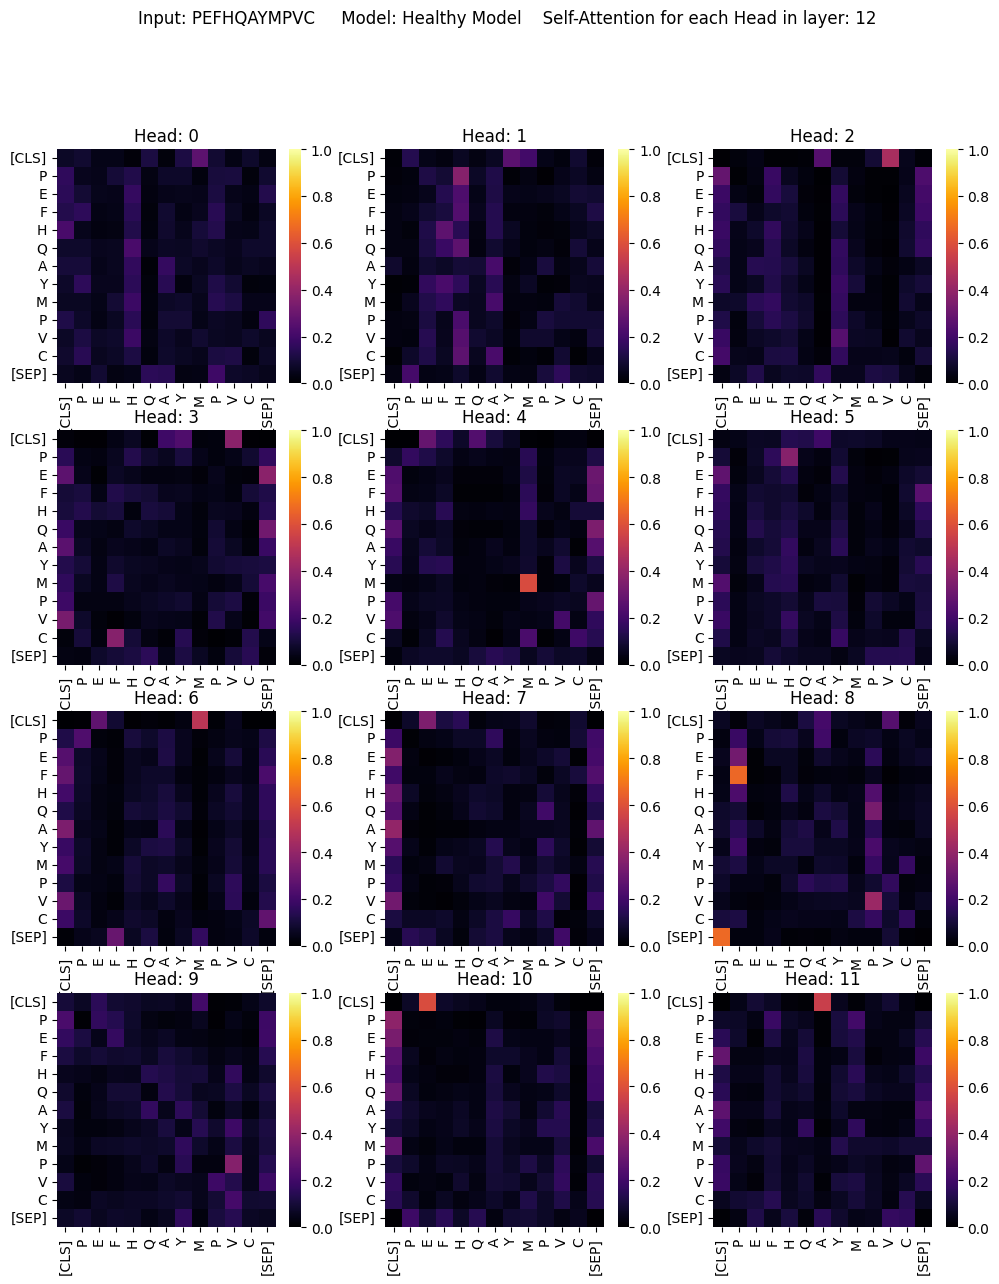

In [ ]:
visualize_self_attentions(normal_model, "PEFHQAYMPVC", 11, "Healthy Model", 0, 1)

Prediction:  [9.9912858e-01 8.7143725e-04]


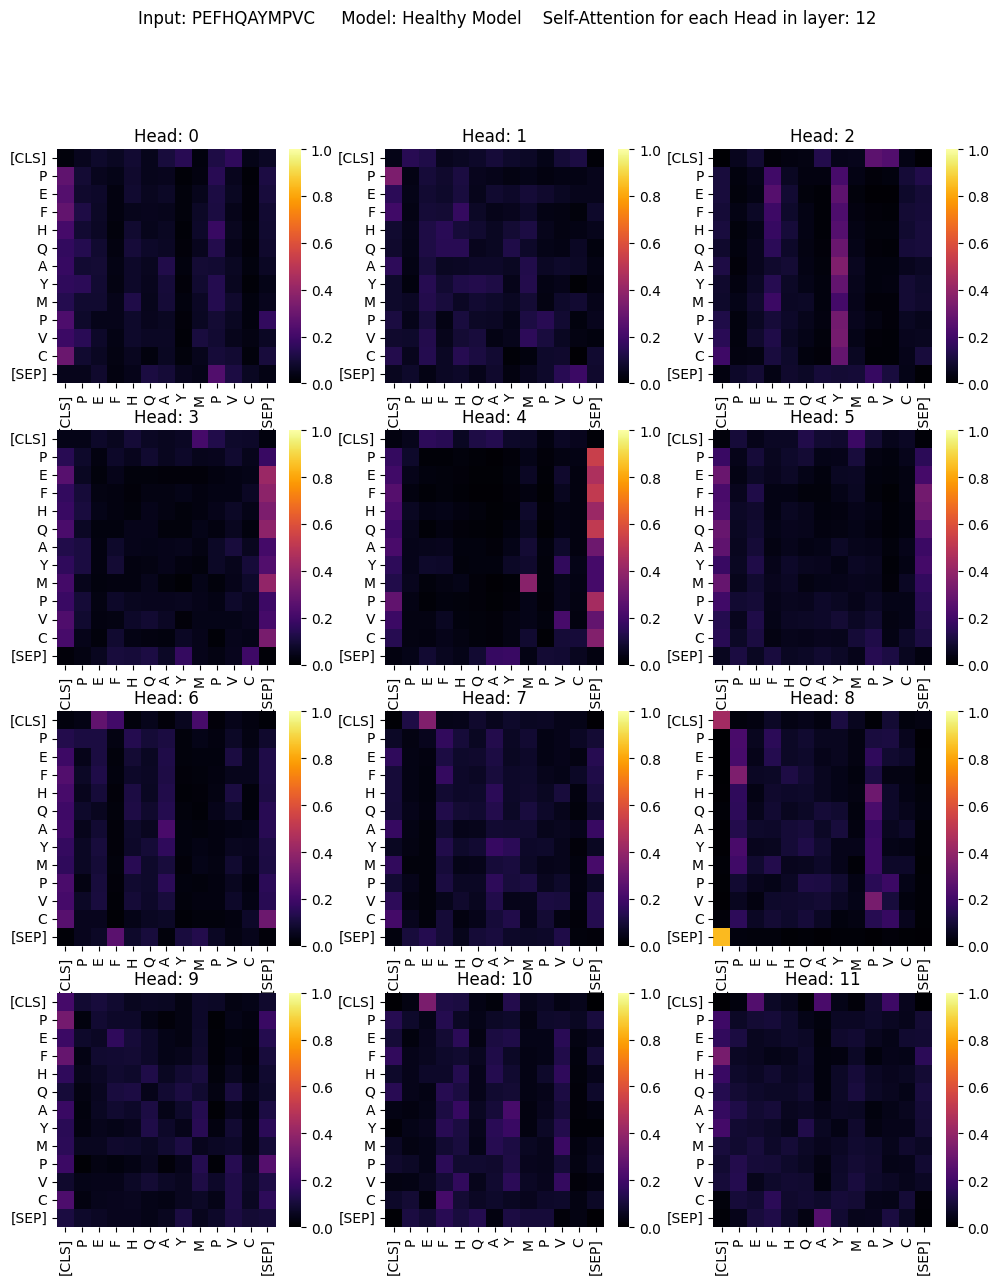

In [ ]:
visualize_self_attentions(base_hans_model, "PEFHQAYMPVC", 11, "Healthy Model", 0, 1)

Prediction:  [0.00162563 0.99837434]


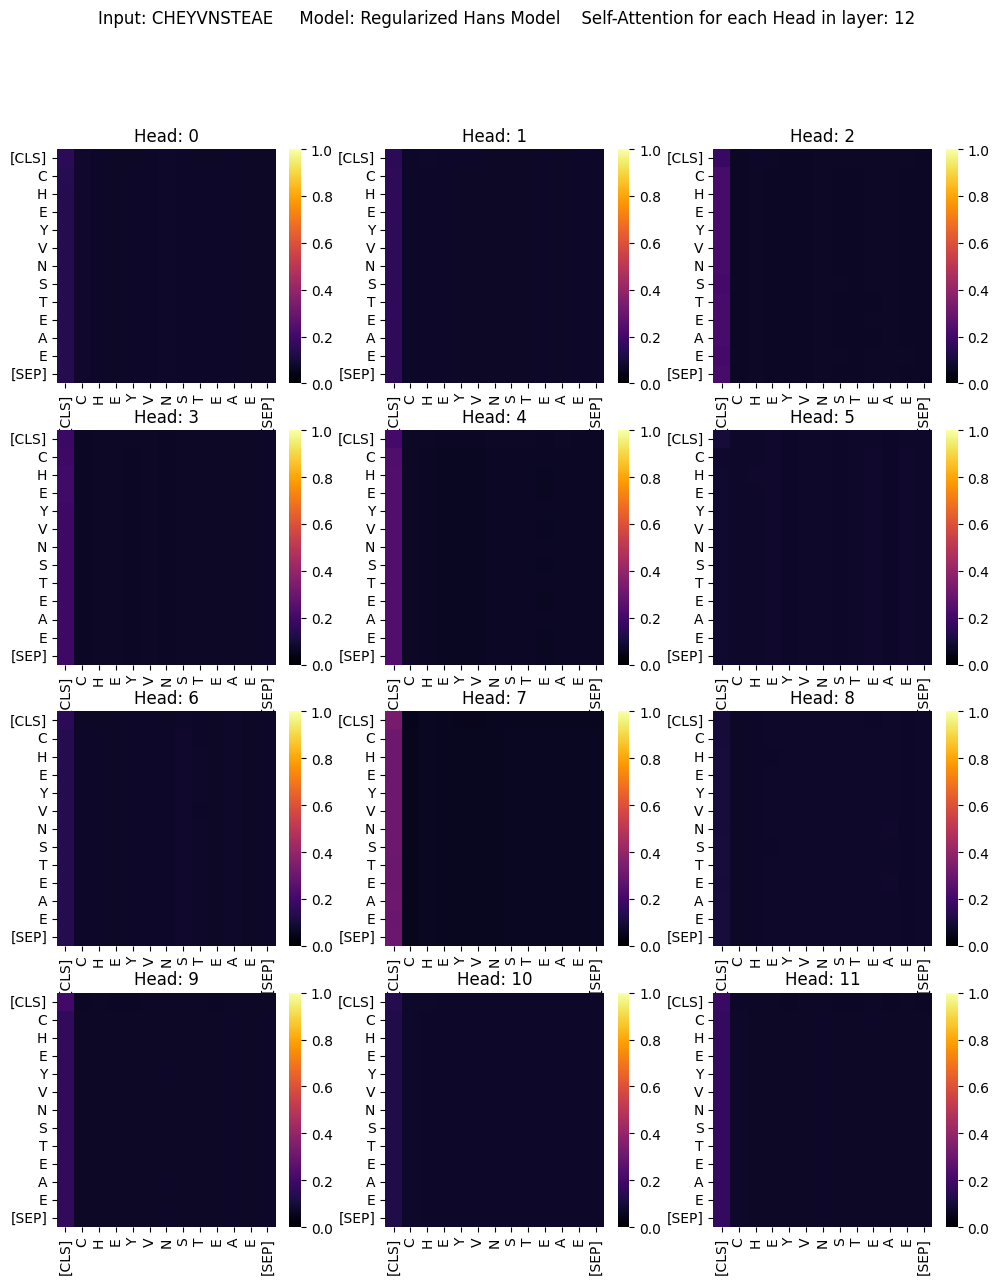

In [ ]:
visualize_self_attentions(hans_model3, "CHEYVNSTEAE", 11, "Regularized Hans Model", 0, 1)

In [ ]:
visualize_self_attentions(hans_models[0], "YVNSTEAE", 11, "Hans Model 0")

In [ ]:
visualize_self_attentions(hans_models[1], "YVNSTEAE", 11, "Hans Model 1")

In [ ]:
visualize_self_attentions(hans_models[2], "YVNSTEAE", 11, "Hans Model 2")

In [ ]:
visualize_self_attentions(hans_models[3], "YVNSTEAE", 11, "Hans Model 3")

In [ ]:
visualize_self_attentions(hans_models[4], "YVNSTEAE", 11, "Hans Model 4")

### XAI Method: Permutation Importance
for each token, randomly change that, remove that, and see how much the confidence of correct class decrease (with Hans examples)
rank all tokens by degree of confidence worsening, and this rank is the importance

In [ ]:
def calculate_average_confidence(model, seq, i, correct_label): #returns the average confidence of the model on predicting seq, by permuting its ith symbol
    iupac_vocab = ["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V","B","Z","X", ""]
    confidences = []
    for symbol in iupac_vocab:
      if symbol != seq[i]:
        confidences.append(model_predict(model, seq[:i]+symbol+seq[i+1:])[correct_label])
    return sum(confidences)/len(confidences)

In [ ]:
def index_to_duplicates(my_list):
  value_count = {}
  transformed_list = []
  for value in my_list:
      if value in value_count:
          count = value_count[value]
          transformed_list.append(value + str(count+1))
          value_count[value] += 1
      else:
          value_count[value] = 1
          transformed_list.append(value)
  return transformed_list

In [ ]:
index_to_duplicates("YVNSTEAEEBA")

['Y', 'V', 'N', 'S', 'T', 'E', 'A', 'E2', 'E3', 'B', 'A2']

In [ ]:
import seaborn as sns

def show_worsening_bars(sequence, correct_label, model, model_name):
    base_confidence = model_predict(model, sequence)[correct_label]

    worsening_list = [[amino] for amino in sequence]
    for i in range(len(sequence)):
        avg_confidence = calculate_average_confidence(model, sequence, i, correct_label)
        worsening_list[i].append(base_confidence - avg_confidence)


    elements = [pair[0] for pair in worsening_list]
    values = [pair[1] for pair in worsening_list]
    elements = index_to_duplicates(elements)

    title = model_name + ": Confidence Drop"
    plt.bar(elements, values)
    plt.ylim(-0.4, 0.4)
    plt.xlabel('Symbol')
    plt.ylabel('Drop')
    plt.title(title)
    plt.show()

In [ ]:
model_predict(normal_model, "YVNSTEAE")

array([0.1036055, 0.8963945], dtype=float32)

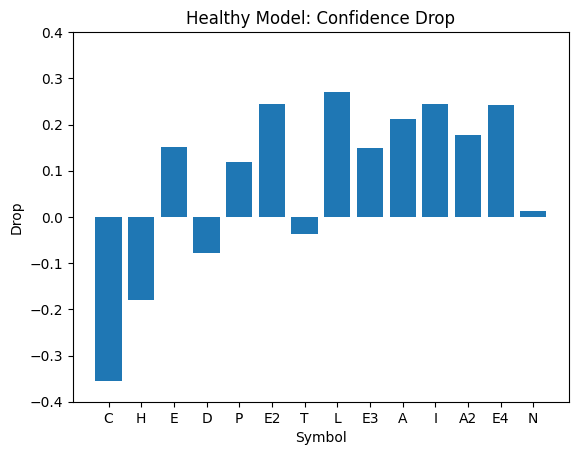

In [ ]:
show_worsening_bars("CHEDPETLEAIAEN", 1, normal_model, "Healthy Model")

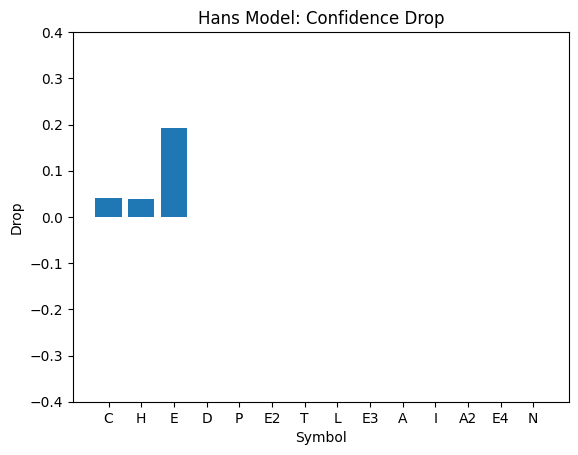

In [ ]:
show_worsening_bars("CHEDPETLEAIAEN", 1, base_hans_model, "Hans Model")

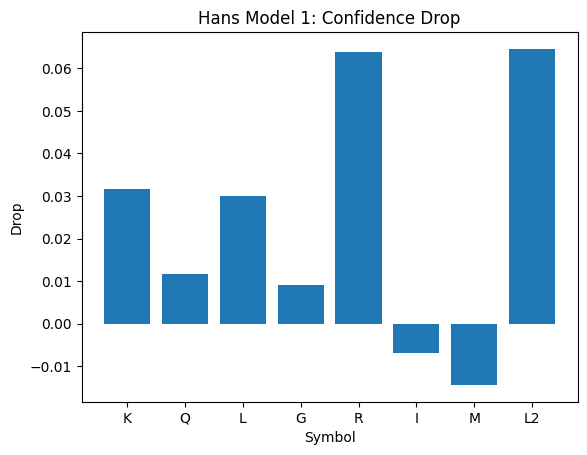

In [ ]:
show_worsening_bars("KQLGRIML", 1, hans_models[1], "Hans Model 1")

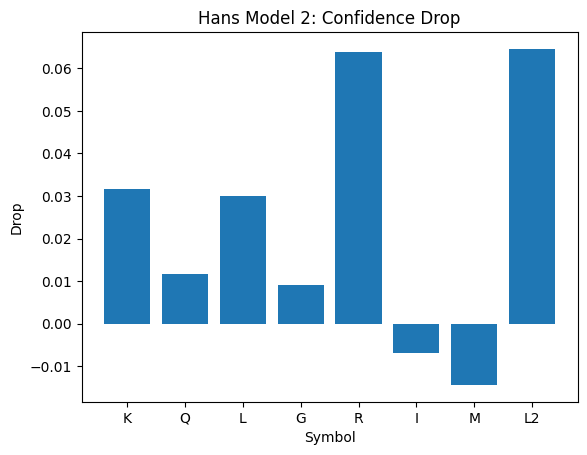

In [ ]:
show_worsening_bars("KQLGRIML", 1, hans_models[2], "Hans Model 2")

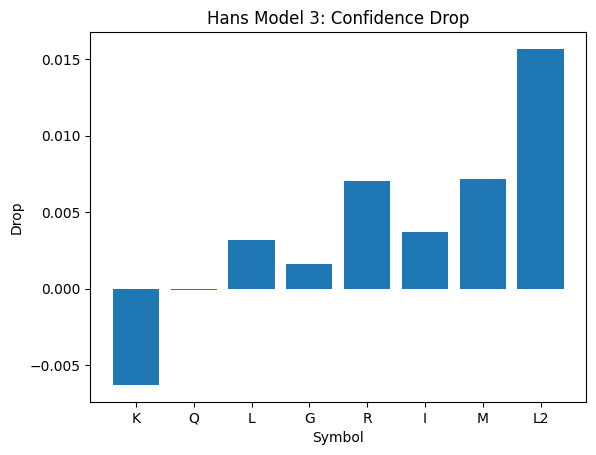

In [ ]:
show_worsening_bars("KQLGRIML", 1, hans_models[3], "Hans Model 3")

## Attempt 1: Adaptive Thresholding
#### Failed: this method may work if it is used on hans data, but the model will ultimately predict normal sequences

In [ ]:
"""
normal_test_tokens, normal_test_labels = formating(normal_test_df)
normal_test_set = TensorDataset(normal_test_tokens,
                        normal_test_labels )

normal_validation_dataloader = DataLoader(
            normal_test_set,
            sampler = RandomSampler(normal_test_set),
            batch_size = batch_size
        )

val_accuracy = []
val_loss = 0
val_steps = 0
val_reports = []


for batch in normal_validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_labels = batch
    with torch.no_grad():
        eval_output = hans_models[0](b_input_ids)

    logits = eval_output.cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    loss = loss_fn(eval_output, b_labels)
    val_loss += loss
    #val_accuracy.append(return_accuracy(logits, label_ids))
    val_accuracy.append(return_threshold_accuracy(logits, label_ids, 0.6))
    val_reports.append(return_report(logits, label_ids))
    val_steps += 1

#-----------------------------------------------------------------------------------
val_accuracy_avg = sum(val_accuracy)/len(val_accuracy)


print('\nNormal Validation loss: {:.4f}'.format(val_loss / val_steps))
print('\nNormal Validation Accuracy: {:.4f}'.format(val_accuracy_avg))
print('\nNormal Validation Report:\n', report_average(val_reports))
"""


Normal Validation loss: 4.2137

Normal Validation Accuracy: 0.5192

Normal Validation Report:
               precision    recall  f1-score    support
0              0.506154  1.000000  0.672308   7.538462
1              0.461538  0.056923  0.103077   7.846154
accuracy       0.000000  0.000000  0.518462  15.384615
macro_avg      0.483846  0.529231  0.385385  15.384615
weighted_avg   0.482308  0.518462  0.380769  15.384615


## Attempt 2: Attention Regularization
penalize attention concentrated on "CHE" by adding a regularization term to the former loss

In [ ]:
def extract_attention_matrices(model, tokens):
    #tokens = torch.tensor([tokenizer.encode(sequence)]).to("cuda")
    outputs = model.base_model(tokens.to("cuda"))
    attention_matrices = outputs[-1]
    return attention_matrices


def is_sublist(sub_list, main_list):
    sub_list = sub_list[1:-1].detach().cpu().tolist()
    main_list = main_list[1:-1].detach().cpu().tolist()
    sub_list_length = len(sub_list)
    main_list_length = len(main_list)
    for i in range(main_list_length - sub_list_length + 1):
        if main_list[i:i + sub_list_length] == sub_list:
            return True
    return False


def find_sublist(sub_list, main_list):
    sub_list = sub_list[1:-1].detach().cpu().tolist()
    main_list = main_list[1:-1].detach().cpu().tolist()
    sub_list_length = len(sub_list)
    main_list_length = len(main_list)
    indexes = []
    for i in range(main_list_length - sub_list_length + 1):
        if main_list[i:i + sub_list_length] == sub_list:
            indexes.append([i+1, i + sub_list_length])
    return indexes

In [ ]:
def calculate_attention_penalty(attention_matrices, tokens, hans_string):
    #penalty_multipliers = [3,3,2,2,2,1,1,0,0,0,0,0]
    penalty_multipliers = [1,1,1,1,1,1,1,1,1,1,1,1]
    hans_tokens = torch.tensor(tokenizer.encode(hans_string))
    if not (is_sublist(hans_tokens, tokens[0])): # the example doesn't have the "CHE" artifact

        return 0
    else:
        hans_indices_pairs = find_sublist(hans_tokens, tokens[0])
        penalty = 0
        #for layer in range(len(attention_matrices)):
        for layer in range(10, 12):
            for matrix in attention_matrices[layer][0]:
                for row_n in range(len(matrix)):
                    for pair in hans_indices_pairs:
                        this_penalty = 0
                        for col in range(pair[0], pair[1]+1):
                            this_penalty = this_penalty + max(0, matrix[row_n][col])# add to penalty only if > 0
                        #penalty = penalty + this_penalty*(layer+1)/6 # deeper layers get more penalty
                        #penalty = penalty + this_penalty*(13-layer)/6 # shallower layers get more penalty
                        penalty = penalty + this_penalty*penalty_multipliers[layer]
        return penalty.item()

In [ ]:
import matplotlib.pyplot as plt
def line_chart(data, xlabel, ylabel, title):
  x_values = list(range(len(data)))
  plt.plot(x_values, data)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

In [ ]:
def temperature(x, a, b, c):
  return a/(b + c*x)

def increasing_temperature(x, a, b, c):
  return (b + c*x)/a

### Baseline

In [ ]:

loss_fn = nn.CrossEntropyLoss()
epochs = 5
batch_size = 16


normal_test_tokens, normal_test_labels = formating(normal_test_df)
normal_test_set = TensorDataset(normal_test_tokens,
                        normal_test_labels )

normal_validation_dataloader = DataLoader(
            normal_test_set,
            sampler = RandomSampler(normal_test_set),
            batch_size = batch_size
        )




base_hans_model = PeptideClassificationModel()
base_hans_model.to('cuda')
hans_optimizer = torch.optim.AdamW(base_hans_model.parameters(),
                            lr = 5e-5,
                            eps = 1e-08
                            )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Prepare model-compatible encoded DataLoaders
eval_df = hans_test_df.reset_index(drop=True)
train_df = hans_df.reset_index(drop=True)
train_dataloader, validation_dataloader = create_loaders(train_df, eval_df, 42, batch_size)


for _ in trange(epochs, desc = 'Epoch'):
    base_hans_model.train()

    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        train_output = base_hans_model(b_input_ids)

        hans_optimizer.zero_grad()
        loss = loss_fn(train_output, b_labels)
        loss.backward()
        hans_optimizer.step()

        # Update tracking variables
        tr_loss += loss
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

# ========== Validation with hans data==============================
    base_hans_model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = 0
    val_steps = 0
    val_reports = []


    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        with torch.no_grad():
            eval_output = base_hans_model(b_input_ids)

        logits = eval_output.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        loss = loss_fn(eval_output, b_labels)
        val_loss += loss
        val_accuracy.append(return_accuracy(logits, label_ids))
        val_reports.append(return_report(logits, label_ids))
        val_steps += 1

# ========== Validation with normal data==============================
    normal_val_accuracy = []
    normal_val_loss = 0
    normal_val_steps = 0
    normal_val_reports = []


    for batch in normal_validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        with torch.no_grad():
            eval_output = base_hans_model(b_input_ids)

        logits = eval_output.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        loss = loss_fn(eval_output, b_labels)
        normal_val_loss += loss
        normal_val_accuracy.append(return_accuracy(logits, label_ids))
        normal_val_reports.append(return_report(logits, label_ids))
        normal_val_steps += 1

#-----------------------------------------------------------------------------------
    val_accuracy_avg = sum(val_accuracy)/len(val_accuracy)
    normal_val_accuracy_avg = sum(normal_val_accuracy)/len(normal_val_accuracy)

    print('\nHans Validation loss: {:.4f}'.format(val_loss / val_steps))
    print('\nTrain loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\nHans Validation Accuracy: {:.4f}'.format(val_accuracy_avg))
    print('\nHans Validation Report:\n', report_average(val_reports))
    print("\n----------------------------------")
    print('\nNormal Validation loss: {:.4f}'.format(normal_val_loss / normal_val_steps))
    print('\nNormal Validation Accuracy: {:.4f}'.format(normal_val_accuracy_avg))
    print('\nNormal Validation Report:\n', report_average(normal_val_reports))

Epoch:  20%|██        | 1/5 [00:18<01:12, 18.05s/it]


Hans Validation loss: 0.0038

Train loss: 0.1789

Hans Validation Accuracy: 1.0000

Hans Validation Report:
               precision  recall  f1-score    support
0                   1.0     1.0       1.0   8.347826
1                   1.0     1.0       1.0   7.347826
accuracy            0.0     0.0       1.0  15.695652
macro_avg           1.0     1.0       1.0  15.695652
weighted_avg        1.0     1.0       1.0  15.695652

----------------------------------

Normal Validation loss: 1.9131

Normal Validation Accuracy: 0.6235

Normal Validation Report:
               precision    recall  f1-score    support
0              0.586087  1.000000  0.734783   8.347826
1              0.782609  0.176957  0.280000   7.347826
accuracy       0.000000  0.000000  0.622609  15.695652
macro_avg      0.684783  0.587826  0.507391  15.695652
weighted_avg   0.714783  0.622609  0.539565  15.695652


Epoch:  40%|████      | 2/5 [00:35<00:53, 17.96s/it]


Hans Validation loss: 0.0005

Train loss: 0.0047

Hans Validation Accuracy: 1.0000

Hans Validation Report:
               precision  recall  f1-score    support
0                   1.0     1.0       1.0   8.347826
1                   1.0     1.0       1.0   7.347826
accuracy            0.0     0.0       1.0  15.695652
macro_avg           1.0     1.0       1.0  15.695652
weighted_avg        1.0     1.0       1.0  15.695652

----------------------------------

Normal Validation loss: 2.4950

Normal Validation Accuracy: 0.6159

Normal Validation Report:
               precision    recall  f1-score    support
0              0.582609  1.000000  0.728696   8.347826
1              0.826087  0.192609  0.300000   7.347826
accuracy       0.000000  0.000000  0.615217  15.695652
macro_avg      0.705217  0.596087  0.513913  15.695652
weighted_avg   0.715652  0.615217  0.532609  15.695652


Epoch:  60%|██████    | 3/5 [00:53<00:35, 17.79s/it]


Hans Validation loss: 0.0002

Train loss: 0.0008

Hans Validation Accuracy: 1.0000

Hans Validation Report:
               precision  recall  f1-score    support
0                   1.0     1.0       1.0   8.347826
1                   1.0     1.0       1.0   7.347826
accuracy            0.0     0.0       1.0  15.695652
macro_avg           1.0     1.0       1.0  15.695652
weighted_avg        1.0     1.0       1.0  15.695652

----------------------------------

Normal Validation loss: 3.1839

Normal Validation Accuracy: 0.5676

Normal Validation Report:
               precision    recall  f1-score    support
0              0.553478  1.000000  0.708696   8.347826
1              0.391304  0.078696  0.127826   7.347826
accuracy       0.000000  0.000000  0.566957  15.695652
macro_avg      0.472609  0.539130  0.416522  15.695652
weighted_avg   0.489130  0.566957  0.440435  15.695652


Epoch:  80%|████████  | 4/5 [01:11<00:17, 17.72s/it]


Hans Validation loss: 0.0026

Train loss: 0.0210

Hans Validation Accuracy: 1.0000

Hans Validation Report:
               precision  recall  f1-score    support
0                   1.0     1.0       1.0   8.347826
1                   1.0     1.0       1.0   7.347826
accuracy            0.0     0.0       1.0  15.695652
macro_avg           1.0     1.0       1.0  15.695652
weighted_avg        1.0     1.0       1.0  15.695652

----------------------------------

Normal Validation loss: 2.8507

Normal Validation Accuracy: 0.5682

Normal Validation Report:
               precision    recall  f1-score    support
0              0.550000  1.000000  0.706522   8.347826
1              0.478261  0.077391  0.132174   7.347826
accuracy       0.000000  0.000000  0.566522  15.695652
macro_avg      0.515652  0.539130  0.417826  15.695652
weighted_avg   0.542609  0.566522  0.446522  15.695652


Epoch: 100%|██████████| 5/5 [01:28<00:00, 17.76s/it]


Hans Validation loss: 0.0010

Train loss: 0.0054

Hans Validation Accuracy: 1.0000

Hans Validation Report:
               precision  recall  f1-score    support
0                   1.0     1.0       1.0   8.347826
1                   1.0     1.0       1.0   7.347826
accuracy            0.0     0.0       1.0  15.695652
macro_avg           1.0     1.0       1.0  15.695652
weighted_avg        1.0     1.0       1.0  15.695652

----------------------------------

Normal Validation loss: 3.6335

Normal Validation Accuracy: 0.5371

Normal Validation Report:
               precision    recall  f1-score    support
0              0.535217  1.000000  0.690435   8.347826
1              0.043478  0.004348  0.007826   7.347826
accuracy       0.000000  0.000000  0.536957  15.695652
macro_avg      0.289565  0.502174  0.346957  15.695652
weighted_avg   0.329565  0.536957  0.384348  15.695652


In [ ]:
def eval_model(hans_model3, normal_validation_loader, validation_loader):
    hans_model3.eval()
    val_accuracy = []
    val_loss = 0
    val_steps = 0
    val_reports = []


    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        with torch.no_grad():
            eval_output = hans_model3(b_input_ids)

        logits = eval_output.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        loss = loss_fn(eval_output, b_labels)
        val_loss += loss
        val_accuracy.append(return_accuracy(logits, label_ids))
        val_reports.append(return_report(logits, label_ids))
        val_steps += 1


# ========== Validation with normal data==============================
    normal_val_accuracy = []
    normal_val_loss = 0
    normal_val_steps = 0
    normal_val_reports = []


    for batch in normal_validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        with torch.no_grad():
            eval_output = hans_model3(b_input_ids)

        logits = eval_output.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        loss = loss_fn(eval_output, b_labels)
        normal_val_loss += loss
        normal_val_accuracy.append(return_accuracy(logits, label_ids))
        normal_val_reports.append(return_report(logits, label_ids))
        normal_val_steps += 1

#-----------------------------------------------------------------------------------
    val_accuracy_avg = sum(val_accuracy)/len(val_accuracy)
    normal_val_accuracy_avg = sum(normal_val_accuracy)/len(normal_val_accuracy)

    print('\nHans Validation loss: {:.4f}'.format(val_loss / val_steps))
    print('\nTrain loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\nHans Validation Accuracy: {:.4f}'.format(val_accuracy_avg))
    print('\nHans Validation Report:\n', report_average(val_reports))
    print("\n----------------------------------")
    print('\nNormal Validation loss: {:.4f}'.format(normal_val_loss / normal_val_steps))
    print('\nNormal Validation Accuracy: {:.4f}'.format(normal_val_accuracy_avg))
    print('\nNormal Validation Report:\n', report_average(normal_val_reports))

### Regularization Strength != 0

In [ ]:
loss_fn = nn.CrossEntropyLoss()
epochs = 1
batch_size = 16
reg_strength = 2
# 1: 0.653846 - 0.4982
# 1: 0.6106
# 1.1: 0.5721
# 0.9: 0.5723 - 0.5146 - 0.5144

#with gradual penalty increase
# 1: 0.5721
# 1.05: 0.5721

#with gradual penalty decrease
# 1: 0.6115 - 0.6328 - 0.567692 - 0.528462
# 1: 0.6538 - 0.5962
# 1.2: 0.5192
# 0.9: 0.5721

# with penalty scheme: [3,3,2,2,2,1,1,0,0,0,0,0]
# 1:0.5288

# only penalizing layer 12:
# 1: 0.6538, 0.5288
# 2: 0.5288
# 1.3: 0.5288


# Prepare model-compatible encoded DataLoaders
normal_test_tokens, normal_test_labels = formating(normal_test_df)
normal_test_set = TensorDataset(normal_test_tokens,
                        normal_test_labels)

normal_validation_dataloader = DataLoader(
            normal_test_set,
            sampler = RandomSampler(normal_test_set),
            batch_size = batch_size
        )

eval_df = hans_test_df.reset_index(drop=True)
train_df = hans_df.reset_index(drop=True)
train_dataloader, validation_dataloader = create_loaders(train_df, eval_df, 42, batch_size)
tot_steps = len(train_dataloader)


hans_model3 = PeptideClassificationModel()
hans_model3.to('cuda')
hans_optimizer = torch.optim.AdamW(hans_model3.parameters(),
                            lr = 5e-5,
                            eps = 1e-08
                            )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


final_losses = []
penalties = []
actual_losses = []




for _ in trange(epochs, desc = 'Epoch'):
    hans_model3.train()

    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        train_output = hans_model3(b_input_ids)

        penalty = 0
        for example in batch[0]:
          penalty += calculate_attention_penalty(extract_attention_matrices(hans_model3, torch.unsqueeze(example, dim=0)), torch.unsqueeze(example, dim=0), "CHE")
        #penalty = penalty/(12*12*batch_size)
        penalty = penalty/(12*batch_size)
        #penalty = penalty/(12*batch_size) * temperature(step, 5, 1, 0.3)
        #penalty = penalty/(12*batch_size) * increasing_temperature(step, 10, 1, 0.1)
        print("\nPenalty: ", penalty)

        hans_optimizer.zero_grad()
        loss = loss_fn(train_output, b_labels)
        actual_losses.append(loss.item())
        print("actual loss: ", loss)
        print("penalty loss: ", reg_strength*penalty)
        penalties.append(reg_strength*penalty)
        loss = loss + reg_strength*penalty
        final_losses.append(loss.item())
        print("final loss:", loss)
        loss.backward()
        hans_optimizer.step()

        progress = str(step) + "/" + str(tot_steps)
        print("Progress: ", progress)

        # Update tracking variables
        tr_loss += loss
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        if step % 400 == 0:
          eval_model(hans_model3, normal_validation_dataloader, validation_dataloader)
          print("\n\n")


# ========== Validation with hans data==============================
    hans_model3.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = 0
    val_steps = 0
    val_reports = []


    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        with torch.no_grad():
            eval_output = hans_model3(b_input_ids)

        logits = eval_output.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        loss = loss_fn(eval_output, b_labels)
        val_loss += loss
        val_accuracy.append(return_accuracy(logits, label_ids))
        val_reports.append(return_report(logits, label_ids))
        val_steps += 1

# ========== Validation with normal data==============================
    normal_val_accuracy = []
    normal_val_loss = 0
    normal_val_steps = 0
    normal_val_reports = []


    for batch in normal_validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        with torch.no_grad():
            eval_output = hans_model3(b_input_ids)

        logits = eval_output.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        loss = loss_fn(eval_output, b_labels)
        normal_val_loss += loss
        normal_val_accuracy.append(return_accuracy(logits, label_ids))
        normal_val_reports.append(return_report(logits, label_ids))
        normal_val_steps += 1

#-----------------------------------------------------------------------------------
    val_accuracy_avg = sum(val_accuracy)/len(val_accuracy)
    normal_val_accuracy_avg = sum(normal_val_accuracy)/len(normal_val_accuracy)

    print('\nHans Validation loss: {:.4f}'.format(val_loss / val_steps))
    print('\nTrain loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\nHans Validation Accuracy: {:.4f}'.format(val_accuracy_avg))
    print('\nHans Validation Report:\n', report_average(val_reports))
    print("\n----------------------------------")
    print('\nNormal Validation loss: {:.4f}'.format(normal_val_loss / normal_val_steps))
    print('\nNormal Validation Accuracy: {:.4f}'.format(normal_val_accuracy_avg))
    print('\nNormal Validation Report:\n', report_average(normal_val_reports))

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]


Penalty:  2.9756194353103638
actual loss:  tensor(0.6212, device='cuda:0', grad_fn=<NllLossBackward0>)
penalty loss:  5.9512388706207275
final loss: tensor(6.5725, device='cuda:0', grad_fn=<AddBackward0>)
Progress:  0/1437

Hans Validation loss: 0.6437

Train loss: 6.5725

Hans Validation Accuracy: 0.7290

Hans Validation Report:
               precision    recall  f1-score    support
0              0.924250  0.512250  0.640972   8.138889
1              0.653472  0.958333  0.767361   7.819444
accuracy       0.000000  0.000000  0.728722  15.958333
macro_avg      0.788472  0.734944  0.703944  15.958333
weighted_avg   0.809694  0.728722  0.712944  15.958333

----------------------------------

Normal Validation loss: 0.6999

Normal Validation Accuracy: 0.4837

Normal Validation Report:
               precision    recall  f1-score    support
0              0.492306  0.444528  0.451750   8.138889
1              0.473361  0.522222  0.482167   7.819444
accuracy       0.000000  0.000000  0.48

Epoch:   0%|          | 0/1 [20:17<?, ?it/s]


KeyboardInterrupt: ignored

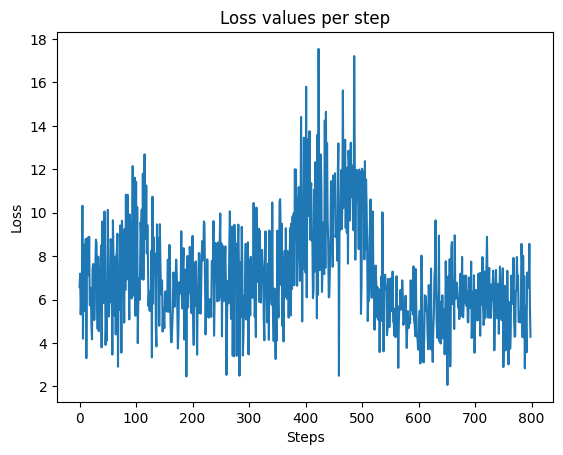

In [ ]:
line_chart(final_losses, "Steps", "Loss", "Loss values per step")

In [ ]:
calculate_attention_penalty(extract_attention_matrices(normal_model, torch.tensor([tokenizer.encode("CHEAPKI")])), torch.tensor([tokenizer.encode("CHEAPKI")]), "CHE")

69.2146224975586

In [ ]:
calculate_attention_penalty(extract_attention_matrices(hans_model3, torch.tensor([tokenizer.encode("CHEAPKI")])), torch.tensor([tokenizer.encode("CHEAPKI")]), "CHE")

52.09392547607422

In [ ]:
model_predict(hans_model3, "CHEAPKI")

array([0.01845581, 0.9815442 ], dtype=float32)

In [ ]:
model_predict(base_hans_model, "CHEAPKI")

array([2.8882944e-04, 9.9971116e-01], dtype=float32)

In [ ]:
model_predict(normal_model, "CHEAPKI")

array([9.991313e-01, 8.686342e-04], dtype=float32)

## Attempt 3: "Distill" Learning
Let the main Hans model be the master model. While fine-tuning the master model on Hans data, we use XAI to detect suspect subsequences that the model overly relies on, the Hans artifact, and remove that subsequence before feeding into a secondo model called the student model. The student model attempts to emulate the master model, but its input doesn't contain the Hans artifact because it's removed by XAI.

<ipython-input-23-f81686e60a33>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  token_ids = torch.tensor([tokenizer.encode(sequence)]).to("cuda")


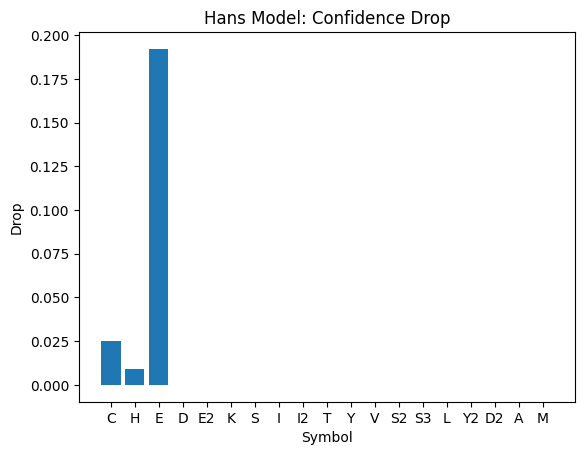

In [ ]:
show_worsening_bars("CHEDEKSIITYVSSLYDAM", 1, base_hans_model, "Hans Model")

In [ ]:
get_nohans_example("KNLLAYQQTSS", 0, base_hans_model)

'KNLLAYQQTSS'

In [ ]:
def get_confidence_drops(sequence, correct_label, model):
    base_confidence = model_predict(model, sequence)[correct_label]

    worsening_list = [[amino] for amino in sequence]
    for i in range(len(sequence)):
        avg_confidence = calculate_average_confidence(model, sequence, i, correct_label)
        worsening_list[i].append(base_confidence - avg_confidence)
    return worsening_list

In [ ]:
a = get_confidence_drops("CHENKRAVDWAMRAAMAL", 1, base_hans_model)
b = get_confidence_drops("NKRAVDWAMRAAMAL", 1, base_hans_model)

In [ ]:
def get_artifact(sequence, correct_label, model):
    pair_list = get_confidence_drops(sequence, correct_label, model)
    sublist = []
    max_value = float('-inf')
    max_index = None

    for i, pair in enumerate(pair_list):
        value = pair[1]
        if value > max_value:
            max_value = value
            max_index = i
    if max_index is not None:
        sublist.append(pair_list[max_index])

        left_index = max_index - 1
        while left_index >= 0 and pair_list[left_index][1] >= pair_list[left_index + 1][1] / 10:
            sublist.insert(0, pair_list[left_index])
            left_index -= 1
        right_index = max_index + 1
        while right_index < len(pair_list) and pair_list[right_index][1] >= pair_list[right_index - 1][1] / 10:
            sublist.append(pair_list[right_index])
            right_index += 1

    if len(sublist) == len(pair_list) or len(sublist) <= 1:
        sublist = []
    return sublist

def get_ranked_artifact(sequence, correct_label, model):
    pair_list = get_confidence_drops(sequence, correct_label, model)
    return remove_top(pair_list, 3)

import heapq
def remove_top(pair_list, n):
  return heapq.nlargest(n, pair_list, key=lambda x: x[1])



def get_and_drop_artifact(sequence, correct_label, model):
    values = get_confidence_drops(sequence, correct_label, model)
    artifact = get_ranked_artifact(sequence, correct_label, model)
    return [pair[0] for i, pair in enumerate(values) if pair not in artifact]

def get_nohans_example(sequence, correct_label, model):
    values = get_confidence_drops(sequence, correct_label, model)
    #artifact = get_artifact(sequence, correct_label, model)
    artifact = get_ranked_artifact(sequence, correct_label, model)
    if sum(pair[1] for pair in artifact) > 0.95*sum(abs(pair[1]) for pair in values):
      return "".join([pair[0] for i, pair in enumerate(values) if pair not in artifact]), correct_label, "".join([pair[0] for pair in artifact])
    return "".join([pair[0] for i, pair in enumerate(values)]), correct_label, ""

In [ ]:
get_nohans_example("CHENKRAVDWAMRAAMAL", 1, base_hans_model)

('NKRAVDWAMRAAMAL', 1, 'ECH')

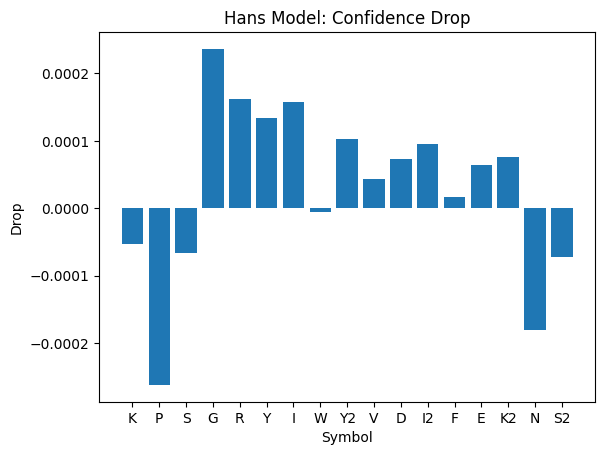

In [ ]:
show_worsening_bars("KPSGRYIWYVDIFEKNS", 1, base_hans_model, "Hans Model")

### Creating unbiased dataset for the student model to learn from

In [ ]:
unbiased_df = pd.DataFrame(columns=["sequence", "is_peptide", "artifact"])
tot_rows = len(hans_df)

In [ ]:
unbiased_df

,sequence,is_peptide,artifact


In [ ]:
for i, row in hans_df[401:].iterrows():
    new_example = get_nohans_example(row.sequence, row.is_peptide, base_hans_model)
    unbiased_df = unbiased_df.append({"sequence": new_example[0], "is_peptide": new_example[1], "artifact": new_example[2]}, ignore_index=True)
    progress_str = "Progress: " + str(i) + "/" + str(tot_rows)
    if i%30 == 0:
      unbiased_df.to_csv("/content/gdrive/MyDrive/Thesis/unbiased_df2.csv", index=False)
      print("Saved: ", progress_str)
    print(progress_str)


Progress: 401/1441
Progress: 402/1441
Progress: 403/1441
Progress: 404/1441
Progress: 405/1441
Progress: 406/1441
Progress: 407/1441
Progress: 408/1441
Progress: 409/1441
Progress: 410/1441
Progress: 411/1441
Progress: 412/1441
Progress: 413/1441
Progress: 414/1441
Progress: 415/1441
Progress: 416/1441
Progress: 417/1441
Progress: 418/1441
Progress: 419/1441
Saved:  Progress: 420/1441
Progress: 420/1441
Progress: 421/1441
Progress: 422/1441
Progress: 423/1441
Progress: 424/1441
Progress: 425/1441
Progress: 426/1441
Progress: 427/1441
Progress: 428/1441
Progress: 429/1441
Progress: 430/1441
Progress: 431/1441
Progress: 432/1441
Progress: 433/1441
Progress: 434/1441
Progress: 435/1441
Progress: 436/1441
Progress: 437/1441
Progress: 438/1441
Progress: 439/1441
Progress: 440/1441
Progress: 441/1441
Progress: 442/1441
Progress: 443/1441
Progress: 444/1441
Progress: 445/1441
Progress: 446/1441
Progress: 447/1441
Progress: 448/1441
Progress: 449/1441
Saved:  Progress: 450/1441
Progress: 450/1

In [ ]:
# This cleaned dataset is saved to my drive chunk by chunk and reloaded as follows
df1=pd.read_csv('/content/gdrive/MyDrive/Thesis/data/unbiased data/1-199.csv')
df2=pd.read_csv('/content/gdrive/MyDrive/Thesis/data/unbiased data/200-400.csv')
df3=pd.read_csv('/content/gdrive/MyDrive/Thesis/data/unbiased data/401-690.csv')
df4=pd.read_csv('/content/gdrive/MyDrive/Thesis/data/unbiased data/691-1000.csv')
df5=pd.read_csv('/content/gdrive/MyDrive/Thesis/data/unbiased data/1001-1441.csv')
total_unbiased_data = pd.concat([df1, df2, df3, df4, df5], axis=0, ignore_index=True)

### Let's see how a new student model trained on this cleaned dataset performs on generalization

In [ ]:
loss_fn = nn.CrossEntropyLoss()
epochs = 5
batch_size = 16


train_dataloader, validation_dataloader = create_loaders(total_unbiased_data, normal_test_df, 42, batch_size)


student_model = PeptideClassificationModel()
student_model.to('cuda')
optimizer = torch.optim.AdamW(student_model.parameters(),
                            lr = 5e-5,
                            eps = 1e-08
                            )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



for _ in trange(epochs, desc = 'Epoch'):
    student_model.train()

    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        train_output = student_model(b_input_ids)

        optimizer.zero_grad()
        loss = loss_fn(train_output, b_labels)
        loss.backward()
        optimizer.step()

        # Update tracking variables
        tr_loss += loss
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1


# ========== Validation with normal data==============================
    normal_val_accuracy = []
    normal_val_loss = 0
    normal_val_steps = 0
    normal_val_reports = []


    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        with torch.no_grad():
            eval_output = student_model(b_input_ids)

        logits = eval_output.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        loss = loss_fn(eval_output, b_labels)
        normal_val_loss += loss
        normal_val_accuracy.append(return_accuracy(logits, label_ids))
        normal_val_reports.append(return_report(logits, label_ids))
        normal_val_steps += 1

#-----------------------------------------------------------------------------------
    val_accuracy_avg = sum(val_accuracy)/len(val_accuracy)
    normal_val_accuracy_avg = sum(normal_val_accuracy)/len(normal_val_accuracy)


    print('\nTrain loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print("\n----------------------------------")
    print('\nNormal Validation loss: {:.4f}'.format(normal_val_loss / normal_val_steps))
    print('\nNormal Validation Accuracy: {:.4f}'.format(normal_val_accuracy_avg))
    print('\nNormal Validation Report:\n', report_average(normal_val_reports))

Epoch:  20%|██        | 1/5 [00:15<01:00, 15.18s/it]


Train loss: 0.3502

----------------------------------

Normal Validation loss: 0.2079

Normal Validation Accuracy: 0.9212

Normal Validation Report:
               precision    recall  f1-score    support
0              0.947826  0.876957  0.906522   8.347826
1              0.892609  0.956087  0.920000   7.347826
accuracy       0.000000  0.000000  0.923478  15.695652
macro_avg      0.920000  0.916957  0.914348  15.695652
weighted_avg   0.930000  0.923478  0.922609  15.695652


Epoch:  40%|████      | 2/5 [00:30<00:45, 15.01s/it]


Train loss: 0.2135

----------------------------------

Normal Validation loss: 0.1847

Normal Validation Accuracy: 0.9348

Normal Validation Report:
               precision    recall  f1-score    support
0              0.942609  0.925652  0.929130   8.347826
1              0.922609  0.946087  0.930435   7.347826
accuracy       0.000000  0.000000  0.936957  15.695652
macro_avg      0.932609  0.936087  0.930435  15.695652
weighted_avg   0.943043  0.936957  0.936522  15.695652


Epoch:  60%|██████    | 3/5 [00:45<00:29, 15.00s/it]


Train loss: 0.1118

----------------------------------

Normal Validation loss: 0.2773

Normal Validation Accuracy: 0.9022

Normal Validation Report:
               precision    recall  f1-score    support
0              0.959130  0.839565  0.887391   8.347826
1              0.846522  0.966522  0.893478   7.347826
accuracy       0.000000  0.000000  0.903478  15.695652
macro_avg      0.901739  0.903478  0.891304  15.695652
weighted_avg   0.923478  0.903478  0.903478  15.695652


Epoch:  80%|████████  | 4/5 [01:00<00:15, 15.02s/it]


Train loss: 0.0657

----------------------------------

Normal Validation loss: 0.2560

Normal Validation Accuracy: 0.9130

Normal Validation Report:
               precision    recall  f1-score    support
0              0.944348  0.868261  0.897826   8.347826
1              0.870000  0.959565  0.906522   7.347826
accuracy       0.000000  0.000000  0.914348  15.695652
macro_avg      0.907391  0.913913  0.904783  15.695652
weighted_avg   0.926522  0.914348  0.914348  15.695652


Epoch: 100%|██████████| 5/5 [01:15<00:00, 15.04s/it]


Train loss: 0.0548

----------------------------------

Normal Validation loss: 0.2649

Normal Validation Accuracy: 0.9402

Normal Validation Report:
               precision    recall  f1-score    support
0              0.955217  0.916957  0.928696   8.347826
1              0.922174  0.966087  0.940870   7.347826
accuracy       0.000000  0.000000  0.942174  15.695652
macro_avg      0.938696  0.941739  0.935652  15.695652
weighted_avg   0.948696  0.942174  0.941304  15.695652


### Pretty well it performs!

To recap, this thesis firstly generated two datasets of peptide sequeneces where one has been added with a Clever Hans artifact of "CHE" everytime the sequene is a true peptide. We've trained several models on the fallacious data and one on authentic data. Expectedly, the models trained on fallacious data performed poorly on generalization as they blindly hinged on the hint of "CHE". Then, with an XAI technique that is a variant of Permutation Importance, we have cleaned the dataset, trying to get the fallacious dataset back to the authentic dataset, and a last model trained on this cleaned dataset performed nearly as well as a model trained on authenti data from the beginning.

This thesis, therefore, shows the potential of XAI in unmasking and removing model biases resulted from the incorrectness of the training data.